# **SemEval 2015 Task 12**

# Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import os
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

     |████████████████████████████████| 4.2 MB 4.8 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 6.6 MB 14.8 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 44.1 MB/s 


**Dataset creation**

In [4]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    sid = sent.attrib['id']
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid # Review id
      row_dict['sid'] = sid # Sentence id
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['f'] = 'yes'
      for opinion in sent[1]:
        op_dict = opinion.attrib
        rows_list.append({**row_dict,**op_dict})
    else:
      rows_list.append({'rid':rid,'sid':sid,'txt':txt,'OOTS':True,'target':np.nan,'category':np.nan,'polarity':np.nan,'from':0,'to':0,'f':'no'})
df = pd.DataFrame(rows_list)

In [ ]:
df['sid'].value_counts()

1726427:1    8
744478:1     7
490565:4     6
1126814:0    5
630914:2     5
            ..
1460715:4    1
1460715:5    1
1470286:1    1
1470334:0    1
958809:4     1
Name: sid, Length: 1315, dtype: int64

**Cartesian product of the categories+polarities**

In [ ]:
import itertools
categories = set(df[df['category'].notna()]['category'].values)
polarities = set(df[df['polarity'].notna()]['polarity'].values)
cat_pol_couples = set(list(itertools.product(categories,polarities)))
print(len(cat_pol_couples))

In [117]:
cat_pol_couples

{('AMBIENCE#GENERAL', 'negative'),
 ('AMBIENCE#GENERAL', 'neutral'),
 ('AMBIENCE#GENERAL', 'positive'),
 ('DRINKS#PRICES', 'negative'),
 ('DRINKS#PRICES', 'neutral'),
 ('DRINKS#PRICES', 'positive'),
 ('DRINKS#QUALITY', 'negative'),
 ('DRINKS#QUALITY', 'neutral'),
 ('DRINKS#QUALITY', 'positive'),
 ('DRINKS#STYLE_OPTIONS', 'negative'),
 ('DRINKS#STYLE_OPTIONS', 'neutral'),
 ('DRINKS#STYLE_OPTIONS', 'positive'),
 ('FOOD#GENERAL', 'negative'),
 ('FOOD#GENERAL', 'neutral'),
 ('FOOD#GENERAL', 'positive'),
 ('FOOD#PRICES', 'negative'),
 ('FOOD#PRICES', 'neutral'),
 ('FOOD#PRICES', 'positive'),
 ('FOOD#QUALITY', 'negative'),
 ('FOOD#QUALITY', 'neutral'),
 ('FOOD#QUALITY', 'positive'),
 ('FOOD#STYLE_OPTIONS', 'negative'),
 ('FOOD#STYLE_OPTIONS', 'neutral'),
 ('FOOD#STYLE_OPTIONS', 'positive'),
 ('LOCATION#GENERAL', 'negative'),
 ('LOCATION#GENERAL', 'neutral'),
 ('LOCATION#GENERAL', 'positive'),
 ('RESTAURANT#GENERAL', 'negative'),
 ('RESTAURANT#GENERAL', 'neutral'),
 ('RESTAURANT#GENERAL', 'po

In [ ]:
cat_pol_couples

**Dataset augmentation with all possible combination of category and polarities different from the one with the values.**

In [6]:
# Dataset augmentation with all possible combination of category and polarities different from the one with the values.
grouped_by_sid = df.groupby('sid').agg(list).reset_index()
new_rows = []
for index, row in grouped_by_sid.iterrows():
  cats = row['category']
  pols = row['polarity']
  current_list = set()
  if len(cats)>0 and (np.nan not in cats):
    for (i,c) in enumerate(cats):
      current_list.add((cats[i],pols[i]))
  for (newc,newpol) in cat_pol_couples.difference(current_list): # nuovi da aggiungere
    new_row = {'rid':row['rid'][0],'sid':row['sid'],'txt':row['txt'][0],'OOTS':'False','target':np.nan,'category':newc,'polarity':newpol,'from':0,'to':0,'f':'no'}
    new_rows.append(new_row)

In [7]:
augmented_dataset_part = pd.DataFrame(new_rows)
df = pd.concat([df,augmented_dataset_part])
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#STYLE_OPTIONS,negative,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#PRICES,negative,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,neutral,0,0


In [8]:
df = df[df['category'].notna()] #this is needed because we already have inserted all the category combinatios also for no opinions reviews.
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#STYLE_OPTIONS,negative,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#PRICES,negative,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,neutral,0,0


**Distribution of opinions over sentences**

In [ ]:
df['f'].value_counts()

no     49780
yes     1654
Name: f, dtype: int64

In [ ]:
df.groupby('sid').agg(len).reset_index()['category'].value_counts()

39    1205
40      84
41      18
42       5
43       2
45       1
Name: category, dtype: int64

**Special character identification**

In [9]:
#special_caracters = [1012, 1010, 1029, 999, 1024] #in order .,?!:
special_caracters = ['.',',','?','!'] #in order .,?!:
intersection = lambda x: list(set.intersection(set(x),set(special_caracters)))
word = "this is a differentiator.,?!:"
print(slow_tokenizer.tokenize(word))
print(slow_tokenizer(word))

['this', 'is', 'a', 'different', '##ia', '##tor', '.', ',', '?', '!', ':']
{'input_ids': [101, 2023, 2003, 1037, 2367, 2401, 4263, 1012, 1010, 1029, 999, 1024, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
t="ao,"
len(t.replace("#",""))

3

**New algorithm for BIO tagging**

In [10]:
import re
cleanString = lambda x: re.sub('\W+','',x)
list_of_tagging_list = []

for index, row in df.iterrows():
  tagging_list = []
  if row['f'] == 'yes':
    txt = row['txt'].split(' ')        # We split the sentence in words with ' ' spaces.
    targets = row['target'].split(' ') # Target:'food pasta pizza'.
    from_ = int(row['from'])
    to = int(row['to']) 
    position = 0
    old_tag = 'O'
    for w in txt:
      tokens = slow_tokenizer.tokenize(w) # We get the token for each word for istance: differentiator, -> ['different', '##ia', '##tor',',']
      for t in tokens: #for each token
        position+=len(t.replace("#",""))
        if position-len(t.replace("#",""))>=from_ and position<=to:
          if old_tag == 'O':
            tagging_list.extend(['B'])
          elif old_tag == 'B':
            tagging_list.extend(['I'])
          else:
            tagging_list.extend(['I'])
        else:
          tagging_list.extend(['O'])
      position+=1 #space
      old_tag = tagging_list[-1]
    token_all_phrase = slow_tokenizer.tokenize(row['txt'])
    # print("txt: {} targets:{} tokens:{} tagging: {} correct: {}".format(txt,targets,token_all_phrase,tagging_list,len(token_all_phrase)==len(tagging_list))) 
  else:
    len_tokens = len(slow_tokenizer.tokenize(row['txt'])) # tags all O
    tagging_list.extend(['O']*len_tokens)
      
  list_of_tagging_list.append(tagging_list)
df['tagging'] = list_of_tagging_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# Check if there are some opinions with Target but without any 'B' in the tagging.
tmp = df[df['target'].notna()]
tmp = tmp[tmp['target']!="NULL"]
sum=0
for i,row in tmp.iterrows():
  if 'B' in row['tagging']:
    sum+=1
  else:
    print("txt:{} tagging:{}".format(row["txt"],row['tagging']))
print(sum)

1279


**New column with category+polarity for the input.**

In [12]:
#add the category column with the polarity.
list_aspects=[]
for i,row in df.iterrows():
  categ=None
  categ = (row["category"].lower()).split('#')
  new_text = categ[0]+" "+categ[1]+" "+row['polarity']
  list_aspects.append(new_text)
df['categ_txt'] = list_aspects
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rid,sid,txt,OOTS,f,target,category,polarity,from,to,tagging,categ_txt
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56,"[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...",restaurant general negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",food quality negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O]",food style_options negative
...,...,...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#STYLE_OPTIONS,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",drinks style_options negative
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,positive,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",location general positive
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#PRICES,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",drinks prices negative
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,LOCATION#GENERAL,neutral,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",location general neutral


In [13]:
def merge_tagging(tags_list): # For each (text, category) the targets do not overlapp
  result = []
  if len(tags_list)==1:
    return tags_list[0]
  for i in range(len(tags_list[0])):
    for t in tags_list:
      val="O"
      if t[i] == "B" or t[i] == "I":
        val = t[i]
        break
      else:
        val = "O"
    result.append(val)
  return result

In [14]:
tagging_frame = df.groupby(["txt", "categ_txt"]).agg(list).reset_index()[['txt','categ_txt','f','tagging']]
tagging_frame['tagging']= tagging_frame['tagging'].apply(lambda x: merge_tagging(x))
tagging_frame['f']= tagging_frame['f'].apply(lambda x: "yes" if "yes" in x else "no")
tagging_frame

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


In [ ]:
tagging_frame[tagging_frame['txt']=="Good spreads, great beverage selections and bagels really tasty."]

In [15]:
#Number of rows with a target in the tagging sequence.
sum=0
for i,row in tagging_frame.iterrows():
  if 'B' in row['tagging']:
    sum+=1
print(sum)

1137


In [17]:
tagging_frame[tagging_frame['f']=="yes"]

,txt,categ_txt,f,tagging
17,$20 for all you can eat sushi cannot be beaten.,food prices positive,yes,"[O, O, O, B, I, I, I, I, I, O, O, O, O]"
56,"$6 and there is much tasty food, all of it fre...",food prices positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
59,"$6 and there is much tasty food, all of it fre...",food quality positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
62,"$6 and there is much tasty food, all of it fre...",food style_options positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
164,(Always ask the bartender for the SEASONAL bee...,drinks quality positive,yes,"[O, O, O, O, O, O, O, B, I, O, O, O]"
...,...,...,...,...
50994,too large for just two people but nothing was ...,food style_options negative,yes,"[O, O, O, O, O, O, O, O, O, O, O]"
51041,we love th pink pony.,restaurant general positive,yes,"[O, O, O, B, I, O]"
51117,"well, i didn't find it there, and trust, i hav...",restaurant general negative,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
51131,"whoever the jazz duo was, they were on POINT.",ambience general positive,yes,"[O, O, B, I, O, O, O, O, O, O, O]"


**Preparing dataset for the model**

In [16]:
df = tagging_frame
df

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


**Convering string values in integers**

In [ ]:
# convert yes,no in 0,1
# convert BIOP -> 0,1,2,3

**Dataset balancing**

In [18]:
from sklearn.utils import shuffle
df_yes = df[df['f']=="yes"]
df_no = df[df['f']=="no"]
df_yes = shuffle(df_yes)
df_no = shuffle(df_no)
df_no = df_no.iloc[:1500]
df=pd.concat([df_yes,df_no])
df = shuffle(df)
df

,txt,categ_txt,f,tagging
30461,The design and atmosphere is just as good.,ambience general positive,yes,"[O, B, O, B, O, O, O, O, O]"
10406,"Have recommended the place to friends, always ...",restaurant miscellaneous positive,yes,"[O, O, O, B, O, O, O, O, O, O, O, O]"
31688,The food is great and reasonably priced.,food quality positive,yes,"[O, B, O, O, O, O, O, O]"
33794,The menu is limited but almost all of the dish...,food quality positive,yes,"[O, O, O, O, O, O, O, O, O, B, O, O, O]"
10832,"However, I think Jeckll and Hydes t is one of ...",restaurant general positive,yes,"[O, O, O, O, B, B, B, I, I, I, O, O, O, O, O, ..."
...,...,...,...,...
35552,The restaurant is a bit noisy but that is some...,food style_options positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
35831,"The sandwiches are dry, tasteless and way over...",restaurant general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
45571,"Went here last night - nice decor, good servic...",food quality neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
39804,This is a nice pizza place with good selection...,location general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# Just Aspects

In [20]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
     |████████████████████████████████| 352 kB 57.4 MB/s 
     |████████████████████████████████| 90 kB 8.0 MB/s 
     |████████████████████████████████| 237 kB 50.5 MB/s 
     |████████████████████████████████| 47.8 MB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 35.5 MB/s 
     |████████████████████████████████| 1.2 MB 39.5 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 


In [21]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from official.nlp import optimization

max_len=266
query_len=10
max_len_txt=max_len-query_len

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
# bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert


In [ ]:
#For loading hub layers from HUB in TPUs
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

In [22]:
epochs=1
def create_model():
    ## BERT encoder
    #encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,0]
    # ['pooler_output']
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(32, activation="tanh")(embedding)
    # output = layers.Dense(1, activation='sigmoid')(l)
    output = layers.Dense(2, activation='softmax')(l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output],
    )
    METRICS = [
              tf.keras.metrics.CategoricalAccuracy(),
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()
    ]
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    steps_per_epoch = df.shape[0]
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    # model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    return model

In [ ]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.36.179.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.179.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_10[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]',         

In [ ]:
from sklearn.utils import shuffle

#Proviamo ad effettuare uno shaffling
df = shuffle(df)
df.shape

In [ ]:
def create_ds():
  y = []
  val_y = []
  vl_size = 10
  num=0
  zeri=False
  input_ids= []
  token_type_ids= []
  attention_mask= []

  vl_input_ids= np.zeros((vl_size, max_len),dtype=np.dtype('i'))
  vl_token_type_ids= np.zeros((vl_size, max_len),dtype=np.dtype('i'))
  vl_attention_mask= np.zeros((vl_size, max_len),dtype=np.dtype('i'))

  for i,row in df.iterrows():
    dic = slow_tokenizer(row['txt'], text_pair=row['categ_txt'])
    dic['input_ids'].extend([0]*(max_len-len(dic['input_ids'])))
    dic['token_type_ids'].extend([1]*(max_len-len(dic['token_type_ids'])))
    dic['attention_mask'].extend([0]*(max_len-len(dic['attention_mask'])))
    f=1 if row['f']=='yes' else 0
    if num<5 and f==1 and zeri==False:
      vl_input_ids[num]=dic['input_ids']
      vl_token_type_ids[num]=dic['token_type_ids']
      vl_attention_mask[num]=dic['attention_mask']
      val_y.append(f)
      if len(val_y)==3:
        zeri=True
      num+=1
    elif num<vl_size and f==0 and zeri:
      vl_input_ids[num]=dic['input_ids']
      vl_token_type_ids[num]=dic['token_type_ids']
      vl_attention_mask[num]=dic['attention_mask']
      val_y.append(f)
      num+=1
    else:
      input_ids.append(dic['input_ids'])
      token_type_ids.append(dic['token_type_ids'])
      attention_mask.append(dic['attention_mask']) 
      y.append(f)
  x = [tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
    tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32)]
  return x, tf.convert_to_tensor(np.array(y), dtype=tf.dtypes.int32), [vl_input_ids,vl_token_type_ids,vl_attention_mask],tf.convert_to_tensor(np.array(val_y), dtype=tf.dtypes.int32)

In [ ]:
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  f = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)
    f.append(1 if row['f']=='yes' else 0)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
df['f'].value_counts().sort_values().plot(kind = 'barh')
df['f'].value_counts()

In [ ]:
# x_train, y_train, val_x, val_y = create_ds()
x_train, y_train_t, y_train = create_inputs_targets()

In [ ]:
bs=8
epochs = 1
"""history = model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)"""
history = model.fit(x=x_train, y=y_train,
                    validation_split=0.1, batch_size=bs,
                               epochs=epochs)

338/338 [==============================] - 32s 94ms/step - loss: 0.2167 - accuracy: 0.9119 - val_loss: 0.3460 - val_accuracy: 0.8771


In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Inference**

In [ ]:
#Inference
# c=("The pizza was very good but the service wasn't.","food quality positive")
# c=("The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing.", "food quality positive")
c=("The spaghetti were very tasty.","food quality positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out

array([[0.7843974 , 0.21560262]], dtype=float32)

In [ ]:
x = slow_tokenizer(text = "The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing.", text_pair="food quality positive")
# x = slow_tokenizer(text = "Told us to sit anywhere.", text_pair="service general negative")
x['input_ids'].extend([0]*(max_len-len(x['input_ids'])))
x['token_type_ids'].extend([1]*(max_len-len(x['token_type_ids'])))
x['attention_mask'].extend([0]*(max_len-len(x['attention_mask'])))
out = model([np.array([x['input_ids']]),np.array([x['token_type_ids']]),np.array([x['attention_mask']])])
out.numpy()

array([[0.5656929, 0.4343071]], dtype=float32)

In [ ]:
# model.save("/content/drive/MyDrive/HLT/class_model.h5")

# Just Entity recognition

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=266
query_len=10
max_len_txt=max_len-query_len

In [ ]:
# slow_tokenizer("")
# cat_pol_couples
for c,p in cat_pol_couples:
  ctl=c.lower().split("#")
  q=ctl[0]+" "+ctl[1]+" "+p
  tokenized=slow_tokenizer.tokenize(q)
  print(len(tokenized))
#6 in the max number of tokens for the query.

In [28]:
ex = ("Not impressed with the food.","food quality negative")
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct
len(tokenize_couple(ex)['input_ids'])

266

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train = create_inputs_targets()

In [ ]:
x_train[0][0][1:max_len_txt]

In [ ]:
y_train[0]

<tf.Tensor: shape=(255,), dtype=int32, numpy=
array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)>

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)


def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,:max_len_txt-1,:]
    embedding = layers.Dropout(0.2)(embedding)
    l = layers.Dense(32,activation="tanh")(embedding)
    tag_logits = layers.Dense(num_tags, activation='softmax')(l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])
    return model

In [ ]:
def our_accuracy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32, name=None)
  y_pred = tf.cast(y_pred, tf.int32, name=None)
  mask = tf.math.logical_not(tf.math.equal(y_true, 3))
  total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32))
  mask = tf.cast(mask, dtype=tf.int32)
  # argmax_out = np.argmax(y_pred,-1)
  argmax_out = tf.math.argmax(
    y_pred,
    axis=-1,
    output_type=tf.dtypes.int32,
    name=None
  )
  print(y_true)
  print(mask)
  y_true *= mask
  argmax_out *= mask
  elements_equal_to_value = tf.equal(y_true, argmax_out)
  as_ints = tf.cast(elements_equal_to_value, tf.int32)
  count = tf.reduce_sum(as_ints)
  res = (count-(tf.size(y_true)-total_no_padding))/total_no_padding
  return res

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.62.45.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.62.45.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_19[0][0]',               
                                thPoolingAndCrossAt               'input_21[0][0]',         

In [ ]:
bs = 16
# bs=8

model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)

169/169 [==============================] - 123s 194ms/step - loss: 0.0108 - accuracy: 0.0683 - val_loss: nan - val_accuracy: 0.0659


**Inference**

In [ ]:
# c=("The pizza was very good but the service wasn't.","food quality negative")
c=("The spaghetti were very tasty.","food general positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out = np.array(out)
argmax_out = np.argmax(out,-1)
tag_list = ["O","B","I","P"]
for i,t in enumerate(slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")):
  print("{}-{} ".format(t,tag_list[argmax_out[0][i]]))

[CLS]-O 
the-O 
spaghetti-B 
were-O 
very-O 
ta-O 
##sty-O 
.-O 
[SEP]-O 


**Save the model**

In [ ]:
#model.save("/content/drive/MyDrive/HLT/ner_model.h5")

# Final model

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=266
query_len=10
max_len_txt=max_len-query_len

In [ ]:
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct
# len(tokenize_couple(ex)['input_ids'])

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  f = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)
    f.append(1 if row['f']=='yes' else 0)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train_t, y_train_f = create_inputs_targets()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    out = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )
    # Tagging layers
    embedding_txt = out['last_hidden_state'][:,:max_len_txt-1,:]
    embedding_txt = layers.Dropout(0.2)(embedding_txt)
    l_txt = layers.Dense(32,activation="tanh")(embedding_txt)
    output_tag = layers.Dense(num_tags, activation='softmax',name="ner_output")(l_txt)

    # Classification layers
    embedding_f = out['last_hidden_state'][:,0,:]
    embedding_f = layers.Dropout(0.1)(embedding_f)
    l_f = layers.Dense(32, activation="tanh")(embedding_f)
    output_f = layers.Dense(2, activation='softmax',name="category_output")(l_f)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output_f,output_tag],
    )
    losses = {
      "category_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      "ner_output": masked_ce_loss,
    }
    lossWeights = {"category_output": 1.0, "ner_output": 1.0}
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    model.compile(optimizer='adam', loss=losses, metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')],loss_weights=lossWeights)
    return model

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.62.45.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.62.45.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


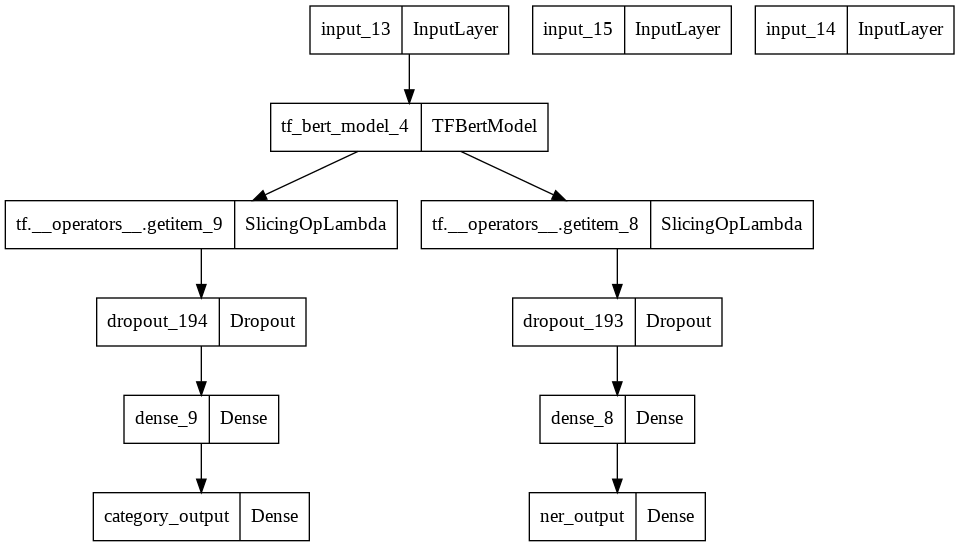

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        final_model = create_model(num_tags)
else:
    final_model = create_model(num_tags)
    
tf.keras.utils.plot_model(final_model)

In [ ]:
bs = 16
# bs=8

final_model.fit(
    x=x_train,
    y={"category_output":y_train_f, "ner_output":y_train_t},
    epochs=3,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 125s 178ms/step - loss: 0.7143 - category_output_loss: 0.6974 - ner_output_loss: 0.0169 - category_output_accuracy: 0.5531 - ner_output_accuracy: 0.0709 - val_loss: nan - val_category_output_loss: 0.9466 - val_ner_output_loss: nan - val_category_output_accuracy: 0.0000e+00 - val_ner_output_accuracy: 0.0681
Epoch 2/3
169/169 [==============================] - 17s 100ms/step - loss: 0.7046 - category_output_loss: 0.6885 - ner_output_loss: 0.0161 - category_output_accuracy: 0.5483 - ner_output_accuracy: 0.0682 - val_loss: nan - val_category_output_loss: 0.8238 - val_ner_output_loss: nan - val_category_output_accuracy: 0.0000e+00 - val_ner_output_accuracy: 0.0681
Epoch 3/3
169/169 [==============================] - 17s 101ms/step - loss: 0.7050 - category_output_loss: 0.6889 - ner_output_loss: 0.0161 - category_output_accuracy: 0.5564 - ner_output_accuracy: 0.0682 - val_loss: nan - val_category_output_loss: 0.8641 - val_ner_output_loss: nan - val_

In [ ]:
#Inference
c=("The pizza was very good but the service wasn't.","food quality positive")
# c=("The spaghetti were very tasty.","food general positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = final_model.predict(x)

In [ ]:
out[0]

array([[0.4214159, 0.5785841]], dtype=float32)

In [ ]:
argmax_out = np.argmax(out[1],-1)
tag_list = ["O","B","I","P"]
for i,t in enumerate(slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")):
  print("{}-{} ".format(t,tag_list[argmax_out[0][i]]))

[CLS]-O 
the-O 
pizza-O 
was-O 
very-O 
good-O 
but-O 
the-O 
service-O 
wasn-O 
'-O 
t-O 
.-O 
[SEP]-O 


# Inference of models

In [23]:
epochs=1
model = create_model()
model.load_weights("/content/drive/MyDrive/HLT/class_model.h5")


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
ner_model = create_model(4)
ner_model.load_weights("/content/drive/MyDrive/HLT/ner_model.h5")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [206]:
from functools import reduce

def inference_function(c,th):
  tokens=tokenize_couple(c)
  x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
  out2 = ner_model.predict(x)
  out1 = model.predict(x)
  out1[out1 < th] = 0 #thresholding.
  indice = np.argmax(out1[0])
  classi=["no","yes"]
  # print(classi[indice])
  tag_couple = []
  if indice==1:
    argmax_out = np.argmax(out2,-1)
    if 1 in argmax_out:
      tag_list = ["O","B","I","P"]
      tokens = slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")
      for i,t in enumerate(tokens):
        tag_couple.append((t,tag_list[argmax_out[0][i]]))
        # print("{}-{}".format(t,tag_list[argmax_out[0][i]]))
      
      tokens = tokens[1:-1] #remove [CLS] and [SEP] tokens
      list_indices = []
      start=0
      end=0
      previous = 'O'
      trovato = False

      for i,(t,tag) in enumerate(tag_couple[1:-1]):
        if tag!='O' and not trovato:
          start=i
          trovato=True
        if trovato and tag=='O':
          end=i
          trovato=False
          list_indices.append((start,end))
      special_caracters=[':','-','$','[',']',')','(','.',',','?','!']
      for z in list_indices:
        parte_asx = tokens[:z[0]]
        from_ = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_asx)))
        space_sx = z[0]
        fake_space_sx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_asx)))
        from_+=space_sx-fake_space_sx

        parte_adx = tokens[:z[1]]
        to = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_adx)))
        space_dx = z[1]
        fake_space_dx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_adx)))
        to+=space_dx-fake_space_dx-1
        print("target={} category={} polarity={} from:{} to:{}".format(c[0][from_:to],"#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],from_,to))
    else:
      print("target={} category={} polarity={} from:{} to:{}".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0))


In [207]:
#c=("I LOOOVE their eggplant pizza, as well as their pastas and their risotti!","food quality positive")
c = ("Good food: my favorite is the seafood spaghetti.","food quality positive")
inference_function(c,0.90)

target=food category=food#quality polarity=positive from:5 to:9
target=seafood spaghetti category=food#quality polarity=positive from:30 to:47


In [202]:
def big_inference(txt,th):
  for cat in cat_pol_couples:
    c = (txt," ".join(cat[0].lower().split("#"))+" "+cat[1])
    inference_function(c,th)

In [203]:
big_inference("The waiter was attentive, the food was delicious and the views of the city were great.", 0.90)

target=NULL category=restaurant#general polarity=positive from:0 to:0
target=food category=food#style_options polarity=positive from:30 to:34
target=NULL category=ambience#general polarity=positive from:0 to:0
target=food category=food#quality polarity=positive from:30 to:34
target=waiter category=service#general polarity=positive from:4 to:10
target=NULL category=location#general polarity=positive from:0 to:0
